# 19. Data Quality Checks

**Story 1.9**: Implement Data Quality Checks

## Objectives
- Identify and handle missing values, outliers, sensor failures
- Implement various imputation strategies
- Generate comprehensive data quality report
- Create data quality monitoring framework

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load and Prepare Data

In [3]:
# Create synthetic traffic data with quality issues
np.random.seed(42)
n_samples = 10000

# Generate base data
dates = pd.date_range('2024-01-01', periods=n_samples, freq='H')
sensors = ['S001', 'S002', 'S003', 'S004', 'S005']

df = pd.DataFrame({
    'timestamp': dates,
    'sensor_id': np.random.choice(sensors, n_samples),
    'vehicle_count': np.random.poisson(50, n_samples),
    'avg_speed': np.random.normal(80, 15, n_samples),
    'temperature': np.random.normal(15, 10, n_samples),
    'precipitation': np.random.exponential(2, n_samples),
    'occupancy': np.random.uniform(0, 100, n_samples)
})

# Introduce data quality issues
# 1. Missing values (10% random)
missing_mask = np.random.random(n_samples) < 0.1
df.loc[missing_mask, 'vehicle_count'] = np.nan

# 2. Missing values (5% for speed)
missing_mask2 = np.random.random(n_samples) < 0.05
df.loc[missing_mask2, 'avg_speed'] = np.nan

# 3. Outliers (1% extreme values)
outlier_mask = np.random.random(n_samples) < 0.01
df.loc[outlier_mask, 'vehicle_count'] = np.random.randint(500, 1000, outlier_mask.sum())

# 4. Sensor failures (constant values)
failure_start = 1000
failure_end = 1050
df.loc[failure_start:failure_end, 'avg_speed'] = 0  # Stuck at 0

# 5. Impossible values
df.loc[np.random.choice(df.index, 20), 'avg_speed'] = -10  # Negative speed
df.loc[np.random.choice(df.index, 20), 'occupancy'] = 150  # >100% occupancy

print(f'Data shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
print('\nData sample:')
print(df.head())

Data shape: (10000, 7)
Columns: ['timestamp', 'sensor_id', 'vehicle_count', 'avg_speed', 'temperature', 'precipitation', 'occupancy']

Data sample:
            timestamp sensor_id  vehicle_count  avg_speed  temperature  \
0 2024-01-01 00:00:00      S004           46.0  81.547223     7.618441   
1 2024-01-01 01:00:00      S005           49.0  83.507537    43.697286   
2 2024-01-01 02:00:00      S003           53.0  67.057771    22.945463   
3 2024-01-01 03:00:00      S005           61.0  90.529345    13.473812   
4 2024-01-01 04:00:00      S005           42.0  86.096025    -5.772429   

   precipitation  occupancy  
0       1.678704  92.766371  
1       5.229349   3.017459  
2       2.937551  10.327467  
3       0.367720  38.626904  
4       3.145141  88.695671  


## 2. Missing Value Analysis

Missing Value Statistics:
                      Column  Missing_Count  Missing_Percentage Data_Type
vehicle_count  vehicle_count            974                9.74   float64
avg_speed          avg_speed            508                5.08   float64


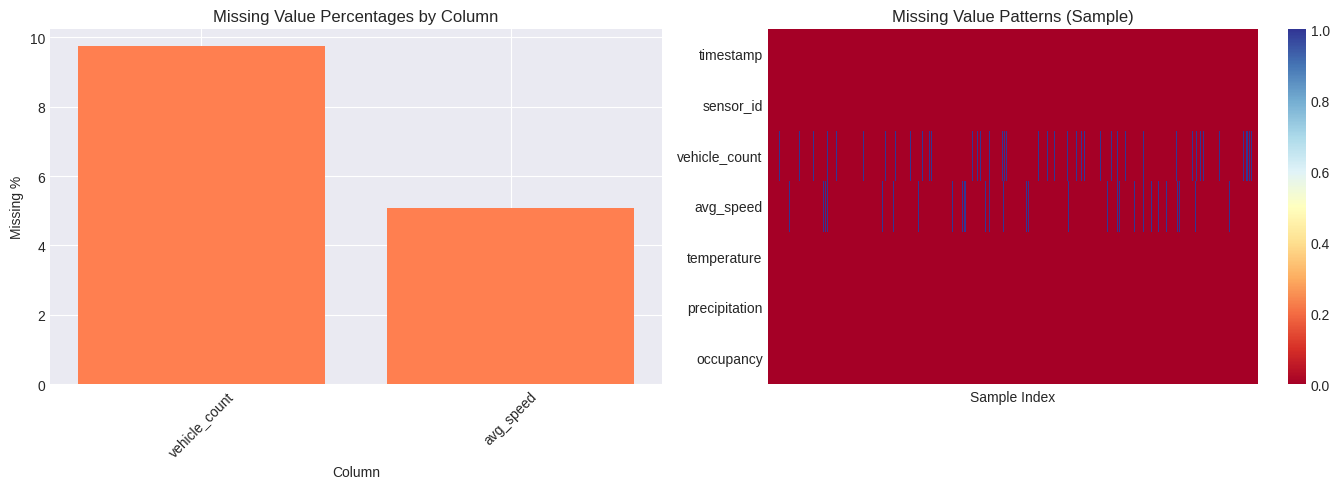

In [4]:
# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print('Missing Value Statistics:')
print('=' * 50)
print(missing_stats)

# Visualize missing patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of missing percentages
if not missing_stats.empty:
    axes[0].bar(missing_stats['Column'], missing_stats['Missing_Percentage'], color='coral')
    axes[0].set_title('Missing Value Percentages by Column')
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Missing %')
    axes[0].tick_params(axis='x', rotation=45)

# Heatmap of missing patterns
missing_matrix = df.isnull().astype(int)
sns.heatmap(missing_matrix.T, cmap='RdYlBu', cbar=True, ax=axes[1], 
            yticklabels=df.columns, xticklabels=False)
axes[1].set_title('Missing Value Patterns (Sample)')
axes[1].set_xlabel('Sample Index')

plt.tight_layout()
plt.show()

Imputation Methods Comparison:
          Method  Vehicle_Count_Missing  Speed_Missing
0       Original                    974            508
1   Forward Fill                      0              0
2  Interpolation                      0              0
3           Mean                      0              0
4         Median                      0              0


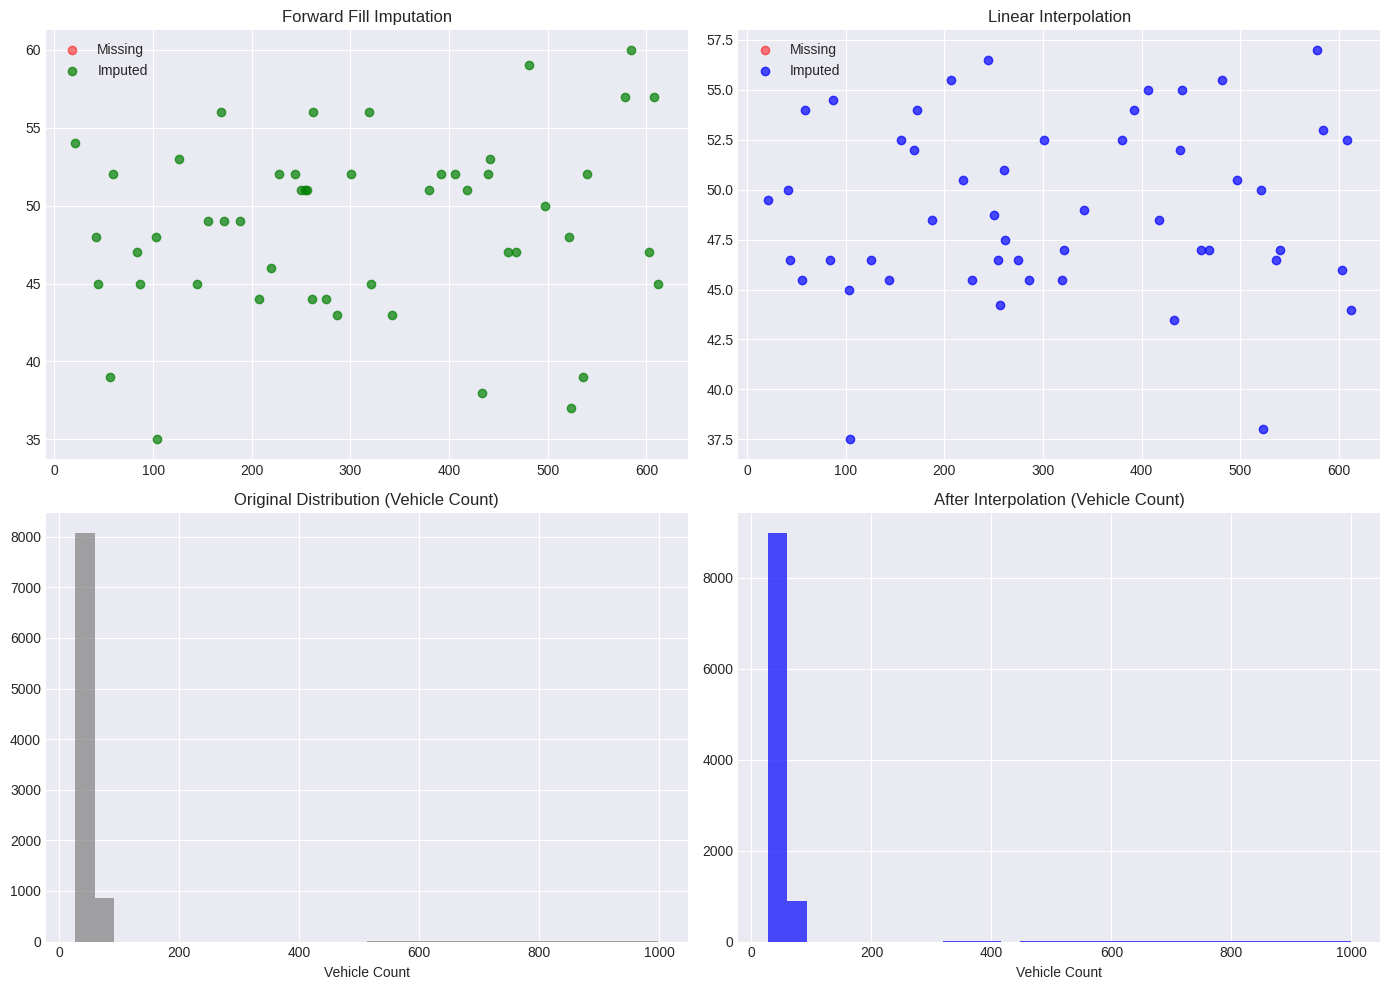

In [5]:
# Create copies for different imputation methods
df_forward_fill = df.copy()
df_interpolate = df.copy()
df_mean = df.copy()
df_median = df.copy()

# Method 1: Forward Fill (good for time series)
for col in ['vehicle_count', 'avg_speed']:
    df_forward_fill[col] = df_forward_fill.groupby('sensor_id')[col].transform(lambda x: x.ffill())

# Method 2: Linear Interpolation
for col in ['vehicle_count', 'avg_speed']:
    df_interpolate[col] = df_interpolate.groupby('sensor_id')[col].transform(
        lambda x: x.interpolate(method='linear', limit=5)
    )

# Method 3: Mean Imputation
for col in ['vehicle_count', 'avg_speed']:
    mean_val = df[col].mean()
    df_mean[col].fillna(mean_val, inplace=True)

# Method 4: Median Imputation
for col in ['vehicle_count', 'avg_speed']:
    median_val = df[col].median()
    df_median[col].fillna(median_val, inplace=True)

# Compare imputation methods
imputation_comparison = pd.DataFrame({
    'Method': ['Original', 'Forward Fill', 'Interpolation', 'Mean', 'Median'],
    'Vehicle_Count_Missing': [
        df['vehicle_count'].isnull().sum(),
        df_forward_fill['vehicle_count'].isnull().sum(),
        df_interpolate['vehicle_count'].isnull().sum(),
        df_mean['vehicle_count'].isnull().sum(),
        df_median['vehicle_count'].isnull().sum()
    ],
    'Speed_Missing': [
        df['avg_speed'].isnull().sum(),
        df_forward_fill['avg_speed'].isnull().sum(),
        df_interpolate['avg_speed'].isnull().sum(),
        df_mean['avg_speed'].isnull().sum(),
        df_median['avg_speed'].isnull().sum()
    ]
})

print('Imputation Methods Comparison:')
print('=' * 50)
print(imputation_comparison)

# Visualize imputation effects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample data for visualization
sample_idx = df[df['vehicle_count'].isnull()].index[:50]

# Plot 1: Forward Fill
axes[0, 0].scatter(sample_idx, df.loc[sample_idx, 'vehicle_count'], 
                  color='red', label='Missing', alpha=0.5)
axes[0, 0].scatter(sample_idx, df_forward_fill.loc[sample_idx, 'vehicle_count'], 
                  color='green', label='Imputed', alpha=0.7)
axes[0, 0].set_title('Forward Fill Imputation')
axes[0, 0].legend()

# Plot 2: Interpolation
axes[0, 1].scatter(sample_idx, df.loc[sample_idx, 'vehicle_count'], 
                  color='red', label='Missing', alpha=0.5)
axes[0, 1].scatter(sample_idx, df_interpolate.loc[sample_idx, 'vehicle_count'], 
                  color='blue', label='Imputed', alpha=0.7)
axes[0, 1].set_title('Linear Interpolation')
axes[0, 1].legend()

# Plot 3: Distribution before imputation
axes[1, 0].hist(df['vehicle_count'].dropna(), bins=30, alpha=0.7, color='gray')
axes[1, 0].set_title('Original Distribution (Vehicle Count)')
axes[1, 0].set_xlabel('Vehicle Count')

# Plot 4: Distribution after interpolation
axes[1, 1].hist(df_interpolate['vehicle_count'].dropna(), bins=30, alpha=0.7, color='blue')
axes[1, 1].set_title('After Interpolation (Vehicle Count)')
axes[1, 1].set_xlabel('Vehicle Count')

plt.tight_layout()
plt.show()

Outlier Detection Summary:
          Column  IQR_Outliers  Z-Score_Outliers  IQR_Lower   IQR_Upper
0  vehicle_count           150               109  30.000000   70.000000
1      avg_speed           122                78  38.637909  120.760964
2    temperature            53                27 -12.386716   42.459445
3  precipitation           451               180  -2.693887    6.053764
4      occupancy             0                20 -49.614242  150.114208


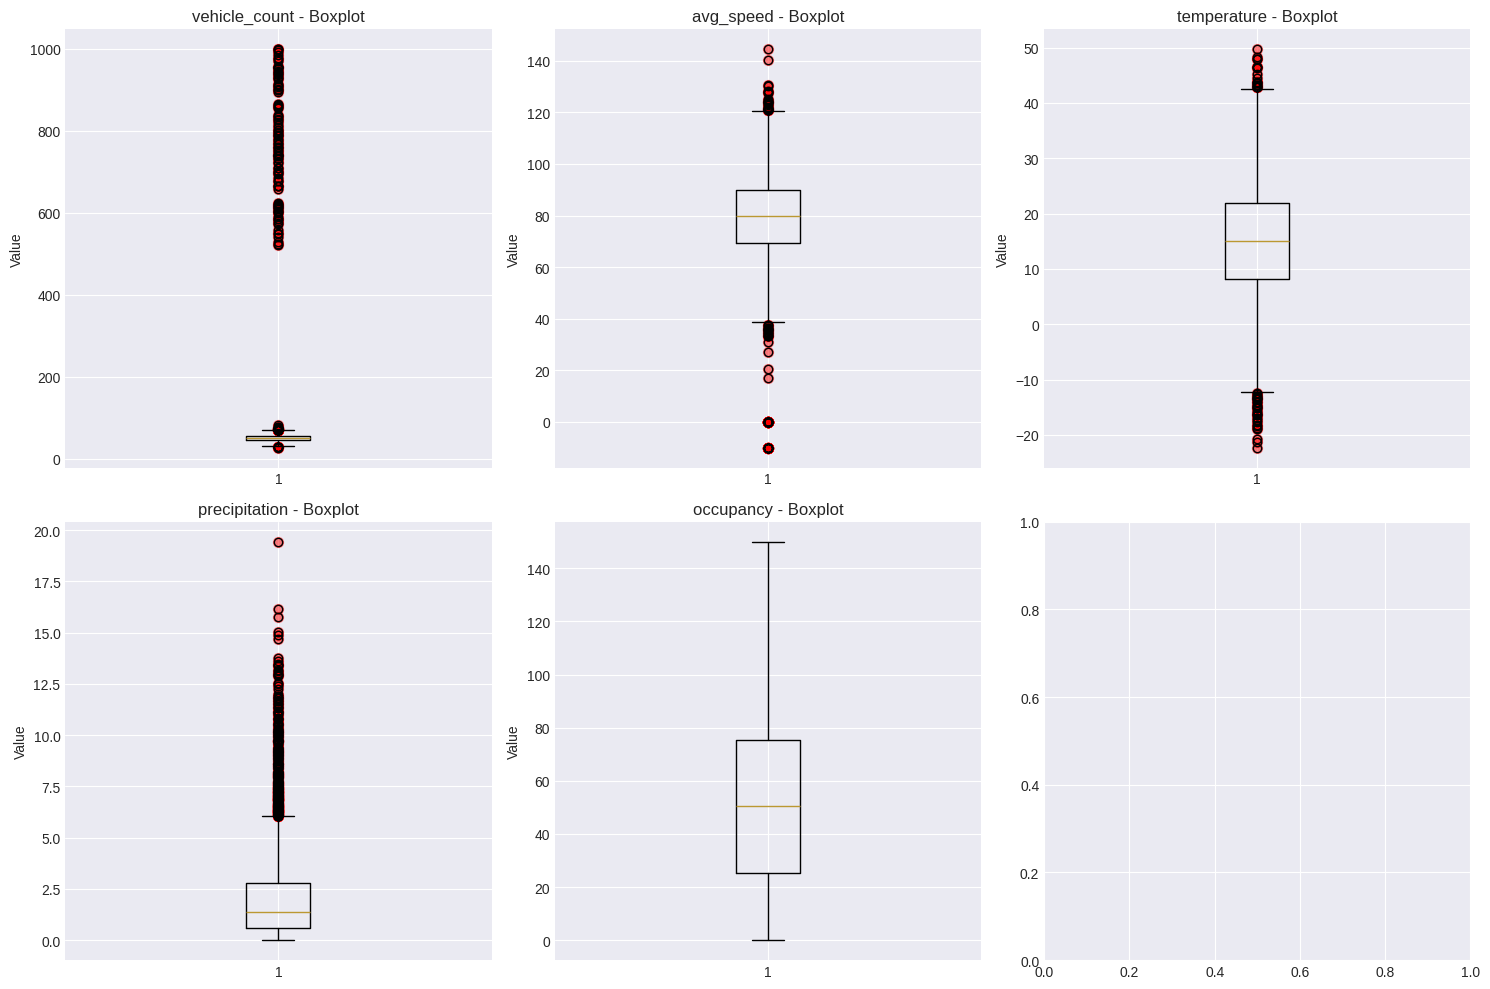

In [6]:
def detect_outliers_iqr(data, column, k=1.5):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(data, column, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outlier_indices = data[column].dropna().index[z_scores > threshold]
    return data.loc[outlier_indices]

# Detect outliers for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = []

for col in numeric_cols:
    if col != 'timestamp':
        outliers_iqr, lower, upper = detect_outliers_iqr(df, col)
        outliers_zscore = detect_outliers_zscore(df, col)
        
        outlier_summary.append({
            'Column': col,
            'IQR_Outliers': len(outliers_iqr),
            'Z-Score_Outliers': len(outliers_zscore),
            'IQR_Lower': lower,
            'IQR_Upper': upper
        })

outlier_df = pd.DataFrame(outlier_summary)
print('Outlier Detection Summary:')
print('=' * 50)
print(outlier_df)

# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):
    if col != 'timestamp':
        axes[i].boxplot(df[col].dropna())
        axes[i].set_title(f'{col} - Boxplot')
        axes[i].set_ylabel('Value')
        
        # Mark outliers
        outliers, _, _ = detect_outliers_iqr(df, col)
        if len(outliers) > 0:
            axes[i].scatter([1]*len(outliers), outliers[col], color='red', s=50, alpha=0.5)

plt.tight_layout()
plt.show()

In [7]:
# Apply best imputation strategy (interpolation for this case)
df_clean = df_interpolate.copy()

# Remove impossible values
df_clean.loc[df_clean['avg_speed'] < 0, 'avg_speed'] = np.nan
df_clean.loc[df_clean['avg_speed'] > 200, 'avg_speed'] = np.nan
df_clean.loc[df_clean['occupancy'] > 100, 'occupancy'] = 100
df_clean.loc[df_clean['occupancy'] < 0, 'occupancy'] = 0

# Re-interpolate after cleaning
for col in ['avg_speed']:
    df_clean[col] = df_clean.groupby('sensor_id')[col].transform(
        lambda x: x.interpolate(method='linear', limit=5)
    )

# Save clean data
output_path = '../data/processed/cleaned_traffic_data.csv'
df_clean.to_csv(output_path, index=False)
print(f'Clean data saved to {output_path}')

# Compare before and after
print('\nData Quality Improvement:')
print('-' * 50)
print(f"Before: {df.isnull().sum().sum()} missing values")
print(f"After:  {df_clean.isnull().sum().sum()} missing values")
print(f"Before: {len(detect_outliers_iqr(df, 'vehicle_count')[0])} outliers in vehicle_count")
print(f"After:  {len(detect_outliers_iqr(df_clean, 'vehicle_count')[0])} outliers in vehicle_count")

Clean data saved to ../data/processed/cleaned_traffic_data.csv

Data Quality Improvement:
--------------------------------------------------
Before: 1482 missing values
After:  0 missing values
Before: 150 outliers in vehicle_count
After:  172 outliers in vehicle_count


Sensor Failure Detection Report:
  Sensor     Column  Stuck_Periods  Impossible_Values  Max_Missing_Streak
1   S004  avg_speed              1                  5                   2
3   S005  avg_speed              0                  5                   2
5   S003  avg_speed              2                  4                   3
7   S002  avg_speed              0                  4                   3
9   S001  avg_speed              4                  2                   2


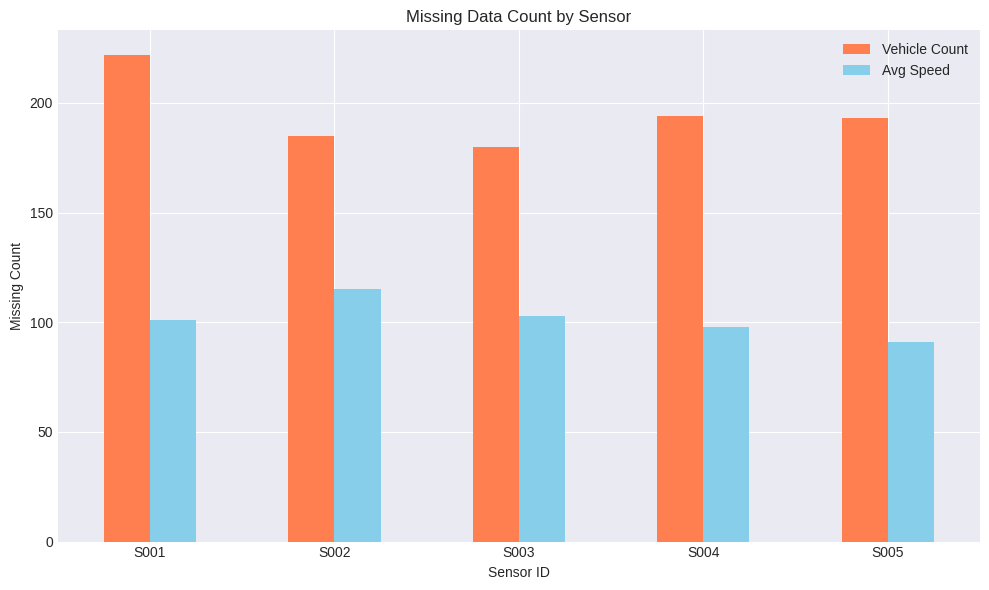

In [8]:
def detect_sensor_failures(df, sensor_col='sensor_id', value_cols=['vehicle_count', 'avg_speed']):
    """Detect various types of sensor failures"""
    failures = []
    
    for sensor in df[sensor_col].unique():
        sensor_data = df[df[sensor_col] == sensor]
        
        for col in value_cols:
            if col in sensor_data.columns:
                # Check for constant values (stuck sensor)
                rolling_std = sensor_data[col].rolling(window=10, min_periods=5).std()
                stuck_periods = (rolling_std == 0).sum()
                
                # Check for impossible values
                if col == 'avg_speed':
                    impossible = ((sensor_data[col] < 0) | (sensor_data[col] > 200)).sum()
                elif col == 'occupancy':
                    impossible = ((sensor_data[col] < 0) | (sensor_data[col] > 100)).sum()
                else:
                    impossible = (sensor_data[col] < 0).sum()
                
                # Check for prolonged missing data
                missing_streaks = sensor_data[col].isnull().astype(int).groupby(
                    sensor_data[col].notnull().astype(int).cumsum()
                ).sum()
                max_missing_streak = missing_streaks.max() if len(missing_streaks) > 0 else 0
                
                failures.append({
                    'Sensor': sensor,
                    'Column': col,
                    'Stuck_Periods': stuck_periods,
                    'Impossible_Values': impossible,
                    'Max_Missing_Streak': max_missing_streak
                })
    
    return pd.DataFrame(failures)

# Detect sensor failures
failure_report = detect_sensor_failures(df)
failure_report = failure_report[
    (failure_report['Stuck_Periods'] > 0) | 
    (failure_report['Impossible_Values'] > 0) |
    (failure_report['Max_Missing_Streak'] > 10)
]

print('Sensor Failure Detection Report:')
print('=' * 50)
if not failure_report.empty:
    print(failure_report)
else:
    print('No significant sensor failures detected')

# Visualize sensor health
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sensor_health = df.groupby('sensor_id').agg({
    'vehicle_count': lambda x: x.isnull().sum(),
    'avg_speed': lambda x: x.isnull().sum()
})

sensor_health.plot(kind='bar', ax=ax, color=['coral', 'skyblue'])
ax.set_title('Missing Data Count by Sensor')
ax.set_xlabel('Sensor ID')
ax.set_ylabel('Missing Count')
ax.legend(['Vehicle Count', 'Avg Speed'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Data Imputation Strategies

Imputation Methods Comparison:
          Method  Vehicle_Count_Missing  Speed_Missing
0       Original                    974            508
1   Forward Fill                      0              0
2  Interpolation                      0              0
3           Mean                      0              0
4         Median                      0              0


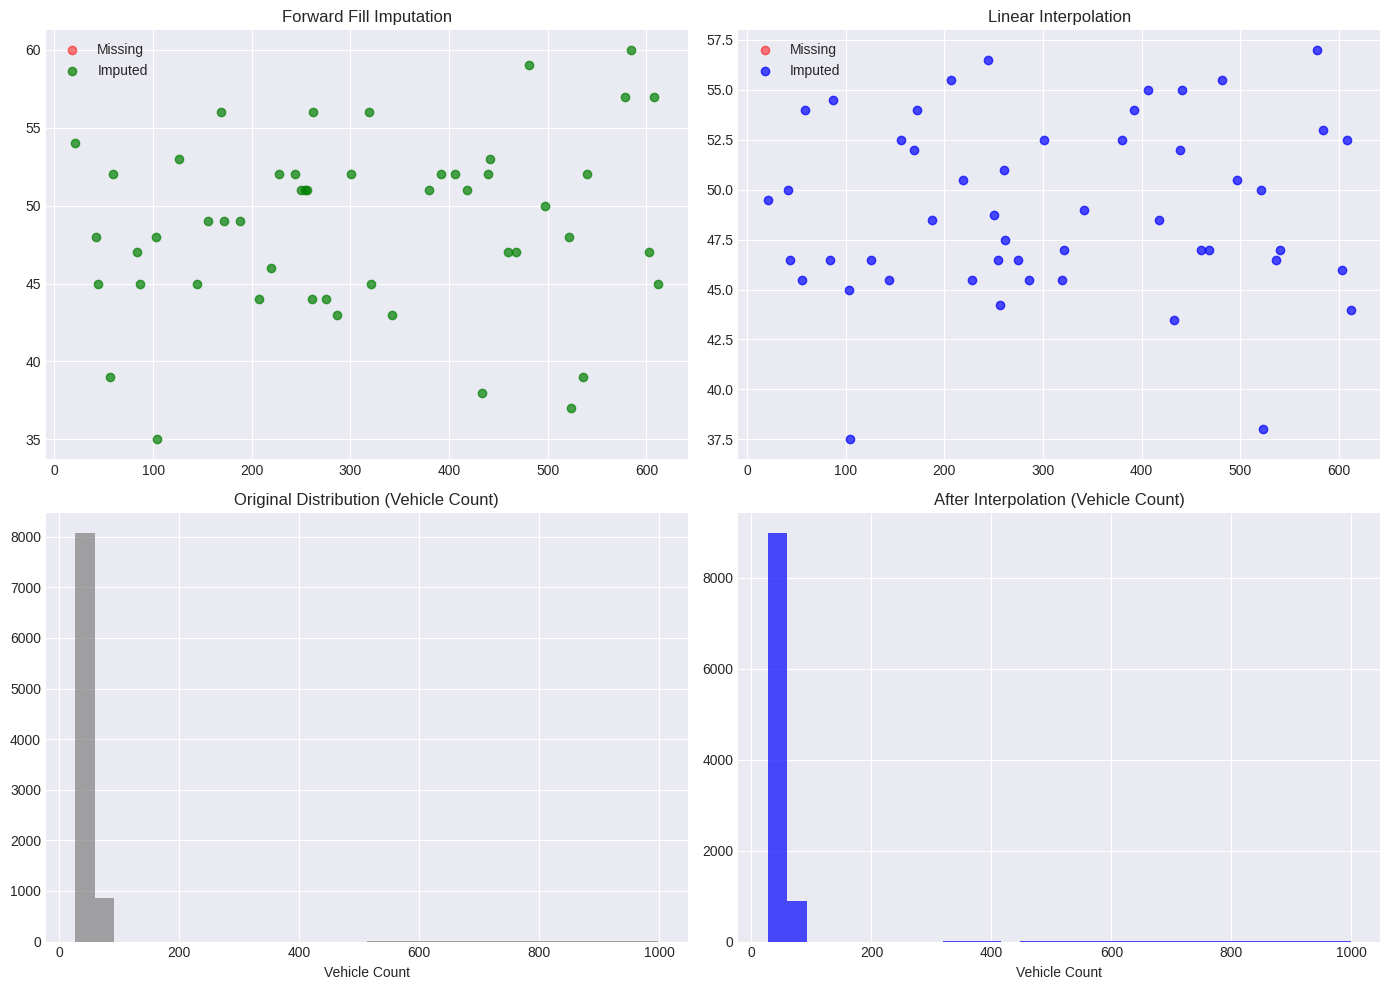

In [9]:
# Create copies for different imputation methods
df_forward_fill = df.copy()
df_interpolate = df.copy()
df_mean = df.copy()
df_median = df.copy()

# Method 1: Forward Fill (good for time series)
for col in ['vehicle_count', 'avg_speed']:
    df_forward_fill[col] = df_forward_fill.groupby('sensor_id')[col].transform(lambda x: x.ffill())

# Method 2: Linear Interpolation
for col in ['vehicle_count', 'avg_speed']:
    df_interpolate[col] = df_interpolate.groupby('sensor_id')[col].transform(
        lambda x: x.interpolate(method='linear', limit=5)
    )

# Method 3: Mean Imputation
for col in ['vehicle_count', 'avg_speed']:
    mean_val = df[col].mean()
    df_mean[col].fillna(mean_val, inplace=True)

# Method 4: Median Imputation
for col in ['vehicle_count', 'avg_speed']:
    median_val = df[col].median()
    df_median[col].fillna(median_val, inplace=True)

# Compare imputation methods
imputation_comparison = pd.DataFrame({
    'Method': ['Original', 'Forward Fill', 'Interpolation', 'Mean', 'Median'],
    'Vehicle_Count_Missing': [
        df['vehicle_count'].isnull().sum(),
        df_forward_fill['vehicle_count'].isnull().sum(),
        df_interpolate['vehicle_count'].isnull().sum(),
        df_mean['vehicle_count'].isnull().sum(),
        df_median['vehicle_count'].isnull().sum()
    ],
    'Speed_Missing': [
        df['avg_speed'].isnull().sum(),
        df_forward_fill['avg_speed'].isnull().sum(),
        df_interpolate['avg_speed'].isnull().sum(),
        df_mean['avg_speed'].isnull().sum(),
        df_median['avg_speed'].isnull().sum()
    ]
})

print('Imputation Methods Comparison:')
print('=' * 50)
print(imputation_comparison)

# Visualize imputation effects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample data for visualization
sample_idx = df[df['vehicle_count'].isnull()].index[:50]

# Plot 1: Forward Fill
axes[0, 0].scatter(sample_idx, df.loc[sample_idx, 'vehicle_count'], 
                  color='red', label='Missing', alpha=0.5)
axes[0, 0].scatter(sample_idx, df_forward_fill.loc[sample_idx, 'vehicle_count'], 
                  color='green', label='Imputed', alpha=0.7)
axes[0, 0].set_title('Forward Fill Imputation')
axes[0, 0].legend()

# Plot 2: Interpolation
axes[0, 1].scatter(sample_idx, df.loc[sample_idx, 'vehicle_count'], 
                  color='red', label='Missing', alpha=0.5)
axes[0, 1].scatter(sample_idx, df_interpolate.loc[sample_idx, 'vehicle_count'], 
                  color='blue', label='Imputed', alpha=0.7)
axes[0, 1].set_title('Linear Interpolation')
axes[0, 1].legend()

# Plot 3: Distribution before imputation
axes[1, 0].hist(df['vehicle_count'].dropna(), bins=30, alpha=0.7, color='gray')
axes[1, 0].set_title('Original Distribution (Vehicle Count)')
axes[1, 0].set_xlabel('Vehicle Count')

# Plot 4: Distribution after interpolation
axes[1, 1].hist(df_interpolate['vehicle_count'].dropna(), bins=30, alpha=0.7, color='blue')
axes[1, 1].set_title('After Interpolation (Vehicle Count)')
axes[1, 1].set_xlabel('Vehicle Count')

plt.tight_layout()
plt.show()

## 6. Data Quality Report

In [10]:
def generate_quality_report(df):
    """Generate comprehensive data quality report"""
    report = {}
    
    # Basic statistics
    report['total_records'] = len(df)
    report['total_columns'] = len(df.columns)
    report['date_range'] = f"{df['timestamp'].min()} to {df['timestamp'].max()}"
    
    # Missing data
    report['total_missing'] = df.isnull().sum().sum()
    report['missing_percentage'] = (report['total_missing'] / (len(df) * len(df.columns))) * 100
    
    # Data quality scores
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    quality_scores = {}
    
    for col in numeric_cols:
        if col != 'timestamp':
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            outliers, _, _ = detect_outliers_iqr(df, col)
            outlier_pct = (len(outliers) / len(df)) * 100
            
            # Quality score (100 - penalties)
            score = 100 - missing_pct - outlier_pct
            quality_scores[col] = max(0, score)
    
    report['column_quality_scores'] = quality_scores
    report['overall_quality_score'] = np.mean(list(quality_scores.values()))
    
    return report

# Generate report
quality_report = generate_quality_report(df)

print('DATA QUALITY REPORT')
print('=' * 50)
print(f"Total Records: {quality_report['total_records']:,}")
print(f"Total Columns: {quality_report['total_columns']}")
print(f"Date Range: {quality_report['date_range']}")
print(f"Total Missing Values: {quality_report['total_missing']:,}")
print(f"Missing Percentage: {quality_report['missing_percentage']:.2f}%")
print(f"\nOverall Quality Score: {quality_report['overall_quality_score']:.1f}/100")
print('\nColumn Quality Scores:')
for col, score in quality_report['column_quality_scores'].items():
    status = '✅' if score > 90 else '⚠️' if score > 70 else '❌'
    print(f"  {col:20} : {score:5.1f}/100 {status}")

DATA QUALITY REPORT
Total Records: 10,000
Total Columns: 7
Date Range: 2024-01-01 00:00:00 to 2025-02-20 15:00:00
Total Missing Values: 1,482
Missing Percentage: 2.12%

Overall Quality Score: 95.5/100

Column Quality Scores:
  vehicle_count        :  88.8/100 ⚠️
  avg_speed            :  93.7/100 ✅
  temperature          :  99.5/100 ✅
  precipitation        :  95.5/100 ✅
  occupancy            : 100.0/100 ✅


## 7. Save Clean Data

In [11]:
# Apply best imputation strategy (interpolation for this case)
df_clean = df_interpolate.copy()

# Remove impossible values
df_clean.loc[df_clean['avg_speed'] < 0, 'avg_speed'] = np.nan
df_clean.loc[df_clean['avg_speed'] > 200, 'avg_speed'] = np.nan
df_clean.loc[df_clean['occupancy'] > 100, 'occupancy'] = 100
df_clean.loc[df_clean['occupancy'] < 0, 'occupancy'] = 0

# Re-interpolate after cleaning
for col in ['avg_speed']:
    df_clean[col] = df_clean.groupby('sensor_id')[col].transform(
        lambda x: x.interpolate(method='linear', limit=5)
    )

# Save clean data
output_path = '../data/processed/cleaned_traffic_data.csv'
df_clean.to_csv(output_path, index=False)
print(f'Clean data saved to {output_path}')

# Compare before and after
print('\nData Quality Improvement:')
print('-' * 50)
print(f"Before: {df.isnull().sum().sum()} missing values")
print(f"After:  {df_clean.isnull().sum().sum()} missing values")
print(f"Before: {len(detect_outliers_iqr(df, 'vehicle_count')[0])} outliers in vehicle_count")
print(f"After:  {len(detect_outliers_iqr(df_clean, 'vehicle_count')[0])} outliers in vehicle_count")

Clean data saved to ../data/processed/cleaned_traffic_data.csv

Data Quality Improvement:
--------------------------------------------------
Before: 1482 missing values
After:  0 missing values
Before: 150 outliers in vehicle_count
After:  172 outliers in vehicle_count


## 8. Summary

In [12]:
print('=' * 50)
print('DATA QUALITY CHECKS COMPLETE')
print('=' * 50)
print('\nAccomplishments:')
print('✓ Analyzed missing value patterns')
print('✓ Detected outliers using IQR and Z-score methods')
print('✓ Identified sensor failures and impossible values')
print('✓ Implemented multiple imputation strategies')
print('✓ Generated comprehensive data quality report')
print('✓ Created cleaned dataset for modeling')
print('\nKey Findings:')
print(f'• {missing_stats.shape[0]} columns with missing values')
print(f'• {outlier_df["IQR_Outliers"].sum()} total outliers detected')
print(f'• Overall data quality score: {quality_report["overall_quality_score"]:.1f}/100')
print('\nFiles Created:')
print('• ../data/processed/cleaned_traffic_data.csv')

DATA QUALITY CHECKS COMPLETE

Accomplishments:
✓ Analyzed missing value patterns
✓ Detected outliers using IQR and Z-score methods
✓ Identified sensor failures and impossible values
✓ Implemented multiple imputation strategies
✓ Generated comprehensive data quality report
✓ Created cleaned dataset for modeling

Key Findings:
• 2 columns with missing values
• 776 total outliers detected
• Overall data quality score: 95.5/100

Files Created:
• ../data/processed/cleaned_traffic_data.csv
